In [1]:
import keras
keras.__version__

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
import os 
import shutil
import nibabel as nib
import numpy as np
import pandas as pd 
from keras.models import load_model
from nilearn import image as nlimg
from keras import backend as K

In [3]:
from keras import layers
from keras import models

model = models.Sequential()

#model.add(layers.AveragePooling3D(pool_size=(3, 3, 3), strides=None, padding='valid',input_shape=(192, 192, 160,1),data_format='channels_last'))
#model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same'))

model.add(layers.AveragePooling3D(pool_size=(2, 2, 2), strides=None, padding='valid',
                         input_shape=(192, 192, 160,1),data_format='channels_last'))
model.add(layers.Conv3D(32, (3, 3, 3), activation='relu',padding='same'))

model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(64, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
model.add(layers.MaxPooling3D((2, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
# model.add(layers.Dense(2, activation='sigmoid'))
model.add(layers.Dense(3, activation='softmax'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling3d_1 (Average (None, 96, 96, 80, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 96, 96, 80, 32)    896       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 48, 48, 40, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 46, 46, 38, 64)    55360     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 23, 23, 19, 64)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 21, 21, 17, 128)   221312    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 10, 8, 128)    0         
__________

In [5]:
from keras import optimizers

#model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1.0, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=adam, 
              metrics=['accuracy'])

In [6]:
#model.load_weights('CN_and_AD_3D_checkpoint.h5')
model.load_weights('CN_AD_MCI_Conv3D_CV_GP2_checkpoint_0.h5')

In [7]:
target_shape = [192,192,160]
target_affine = np.array([ [ 4.29048360e-08,  3.24291396e-04, -1.20006235e+00, 9.47253036e+01],
                            [-3.27969076e-04, -1.23945871e+00, -3.13983739e-04, 1.38530121e+02],
                            [-1.25348123e+00,  3.24300145e-04,  4.10763858e-08, 1.08530121e+02],
                            [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]
                    ])

#NIfTI_img = nib.load('D:\\mri\\Test_AD.nii')
NIfTI_img = nib.load('D:\\mri\\Test_CN.nii')
img = nlimg.resample_img(NIfTI_img, target_affine=target_affine, target_shape=target_shape, interpolation='continuous', copy=True, order='F', clip=True)
img_data = img.get_data()
X = np.empty((1,192, 192, 160, 1))
#X[0,] = img_data
X[0,] = np.expand_dims(img_data, axis=4)

C:\Users\IBM_ADMIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [8]:
print(X.shape)

(1, 192, 192, 160, 1)


In [9]:
# La primera probabilidad corresponde a que el paciente no tenga Alzheimer
# La segunda probabilidad corresponde a que el paciente tenga Alzheimer
preds = model.predict(X)
print(preds)
print(preds.shape)

[[0.9647933  0.00222006 0.0329866 ]]
(1, 3)


In [10]:
np.argmax(preds[0])

0

In [11]:
for j in range(8):
    #print(j)
        
    alzheimer_output = model.output[:, 0]
    #print(model.output)
    last_conv_layer = model.get_layer(index=7)
    #last_conv_layer = model.get_layer('conv3d_4')
    grads = K.gradients(alzheimer_output, last_conv_layer.output)[0] 
    #print(grads)
    pooled_grads = K.mean(grads, axis=(0,1,2,3))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([X])
    for i in range(128):
        conv_layer_output_value[:,:,:, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #print(heatmap.shape)
    
    #print(grads.shape)
    #print(pooled_grads.shape)
    
    import matplotlib.pyplot as plt
    
    if j==0:
        heatmap = heatmap[ 3 , : , : ]
        
    if j==1:
        heatmap = heatmap[ 2 , : , : ]
        
    if j==2:
        heatmap = heatmap[ 1 , : , : ]
        
    if j==3:
        heatmap = heatmap[ : , 3 , : ]
        
    if j==4:
        heatmap = heatmap[ : , 2 , : ]
        
    if j==5:
        heatmap = heatmap[ : , 1 , : ]
        
    if j==6:
        heatmap = heatmap[ : , : , 2 ]
        
    if j==7:
        heatmap = heatmap[ : , : , 1 ]
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
    #print(heatmap.shape)
    
    import cv2
    
    if j==0:
        img = img_data[ 144 , : , : ]
        
    if j==1:
        img = img_data[ 96 , : , : ]
        
    if j==2:
        img = img_data[ 48 , : , : ]
        
    if j==3:
        img = img_data[ : , 144 , : ]
        
    if j==4:
        img = img_data[ : , 96 , : ]
        
    if j==5:
        img = img_data[ : , 48 , : ]
        
    if j==6:
        img = img_data[ : , : , 106 ]
        
    if j==7:
        img = img_data[ : , : , 53 ]
        
    #print(img.shape)
    #plt.imshow(img,cmap=plt.cm.gray)
    plt.imsave('cn_original'+str(j)+'.jpg',img,cmap=plt.cm.gray)

    img = cv2.imread('cn_original'+str(j)+'.jpg')
    #print(img.shape)
    
    heatmap1 = heatmap
    heatmap1 = np.maximum(heatmap1,0)
    heatmap1 /= np.max(heatmap)
    heatmap1 = cv2.resize(1-heatmap,(img.shape[1], img.shape[0]))
    #print(heatmap1.shape)
    heatmap1 = np.uint8(255 * heatmap1)
    #print(heatmap1.shape)
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)
    #print(heatmap1.shape)
    superimposed_img = heatmap1 * 0.4 + img * .6

    #plt.imshow(superimposed_img.astype(np.uint8))
    plt.imsave('cn_heatmap'+str(j)+'.jpg',superimposed_img.astype(np.uint8))

PACIENTE SIN ALZHEIMER:


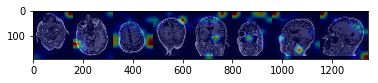

In [12]:
img1 = plt.imread('cn_heatmap0.jpg')
img2 = plt.imread('cn_heatmap1.jpg')
img3 = plt.imread('cn_heatmap2.jpg')
img4 = plt.imread('cn_heatmap3.jpg')
img5 = plt.imread('cn_heatmap4.jpg')
img6 = plt.imread('cn_heatmap5.jpg')
img7 = plt.imread('cn_heatmap6.jpg')
img8 = plt.imread('cn_heatmap7.jpg')
#plt.imshow(img)
print("PACIENTE SIN ALZHEIMER:")
numpy_horizontal1 = np.hstack((img1,img2,img3,img4,img5,img6,img7,img8))
plt.imshow(numpy_horizontal1)

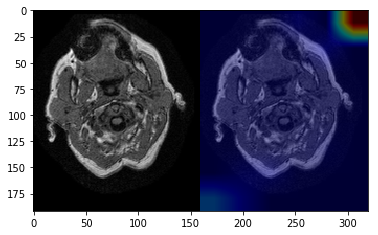

In [13]:
img1_orig = plt.imread('cn_original0.jpg')
numpy_horizontal2 = np.hstack((img1_orig,img1))
plt.imshow(numpy_horizontal2)

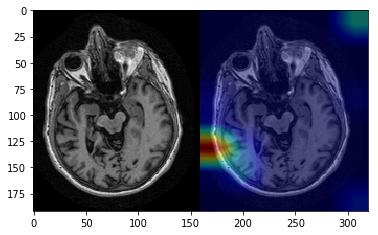

In [14]:
img2_orig = plt.imread('cn_original1.jpg')
numpy_horizontal3 = np.hstack((img2_orig,img2))
plt.imshow(numpy_horizontal3)

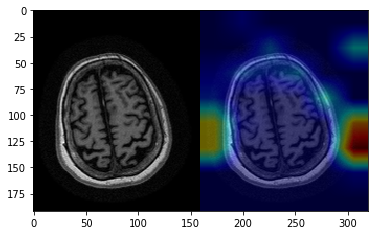

In [15]:
img3_orig = plt.imread('cn_original2.jpg')
numpy_horizontal4 = np.hstack((img3_orig,img3))
plt.imshow(numpy_horizontal4)

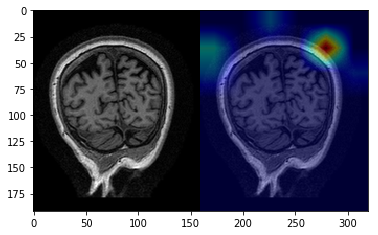

In [16]:
img4_orig = plt.imread('cn_original3.jpg')
numpy_horizontal5 = np.hstack((img4_orig,img4))
plt.imshow(numpy_horizontal5)

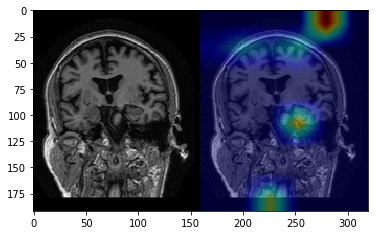

In [17]:
img5_orig = plt.imread('cn_original4.jpg')
numpy_horizontal6 = np.hstack((img5_orig,img5))
plt.imshow(numpy_horizontal6)

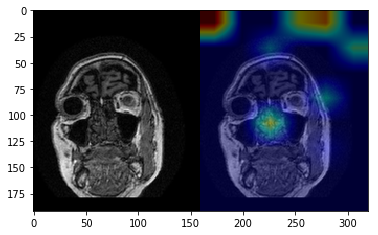

In [18]:
img6_orig = plt.imread('cn_original5.jpg')
numpy_horizontal7 = np.hstack((img6_orig,img6))
plt.imshow(numpy_horizontal7)

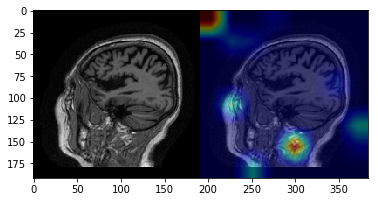

In [19]:
img7_orig = plt.imread('cn_original6.jpg')
numpy_horizontal8 = np.hstack((img7_orig,img7))
plt.imshow(numpy_horizontal8)

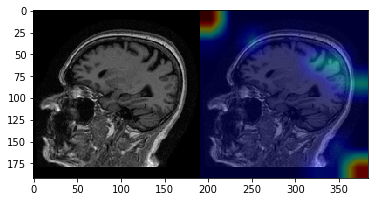

In [20]:
img8_orig = plt.imread('cn_original7.jpg')
numpy_horizontal9 = np.hstack((img8_orig,img8))
plt.imshow(numpy_horizontal9)